# Generation for NLP Baseline Code

```
python3.10 -m venv --system-site-packages /data/ephemeral/home/py310
source /data/ephemeral/home/py310/bin/activate
pip install --upgrade pip
```
위에 커맨드를 사용하여 가상환경을 만들고 IDE의 커널을 생성한 가상환경으로 변경해주세요.

## Install Packages

In [ ]:
# !pip install --no-cache-dir torch==2.9.1+cu128 --index-url https://download.pytorch.org/whl/cu128
# !pip install --no-cache-dir -r requirements.txt

## Import Necessary Libraries

In [2]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /opt/conda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## EDA

### Load Data

In [4]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('/data/ephemeral/pro-nlp-generationfornlp-nlp-13/data/train.csv') 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [5]:
df.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None


### Print missing values

In [6]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
dtype: int64


### Basic information about the dataset

In [7]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


In [6]:

# 1. 선지 개수(num_choices) 계산
# choices 컬럼의 각 리스트의 길이를 젭니다.
df['num_choices'] = df['choices'].apply(len)

# 2. 분포 확인 (4지선다, 5지선다 개수 세기)
print("=== 선지 개수 분포 ===")
print(df['num_choices'].value_counts().sort_index())


# 1. 선지 개수 계산 (아직 안 했다면 수행)
if 'num_choices' not in df.columns:
    df['num_choices'] = df['choices'].apply(len)

# 2. 4지선다 문제 10개 추출
df_4_choices = df[df['num_choices'] == 4].head(10)

# 3. 5지선다 문제 10개 추출
df_5_choices = df[df['num_choices'] == 5].head(10)

# 4. 결과 출력 (텍스트가 잘리지 않게 설정)
pd.set_option('display.max_colwidth', None)


display(df_4_choices[['paragraph']])
display(df_4_choices[['id', 'question', 'choices', 'answer']])

=== 선지 개수 분포 ===
num_choices
4     792
5    1239
Name: count, dtype: int64


,paragraph
0,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다."
1,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사령 박상진을 중심으로 독립군 양성을 목적으로 하였다."
2,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순조로워 우리나라 지맥의 뿌리가 되니 대업을 만대에 전할 땅이다. 왕은 춘하 추동네 계절의 중간달에 그곳에 가 100일 이상 머물러서 나라를 안녕케 하라. － 고려사－
3,"이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다. …(중략) …소정방이 신라군이 늦게 왔다는 이유로 군문에서 신라 독군 김문영의 목을 베고자 하니, 그가 군사들 앞에 나아가 “황산 전투를 보지도 않고 늦게 온 것을 이유로 우리를 죄 주려 하는구나. 죄도 없이 치욕을 당할 수는 없으니, 결단코 먼저 당나라 군사와 결전을 한 후에 백제를 쳐야겠다.”라고 말하였다."
4,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가)이/가 크게 노하여 한성부의 조례(皂隷)와 병졸로 하여 금 한 강 밖으로 몰아내게 하고 드디어 천여 곳의 서원을 철폐하고 그 토지를 몰수하여 관에 속하게 하였다.－대한계년사 －"
5,"(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르기를 “나(대무 예)는 큰 나라를 맡아 여러 주변국을 다스렸으며, 고구려의 옛 땅을 회복하였고 부여의 풍속을 이었다.”라고 하였다."
6,(가)신라의 한강 유역 확보 (나)관산성 전투(다) 백제의 웅진 천도 (라)고구려의 평양 천도
7,"신돈이 (가)을/를 설치하자고 요청하자, …(중략)…이 제 도감이 설치되었다. …(중략)… 명령이 나가자 권세가 중에 전민을 빼앗은 자들이 그 주인에게 많이 돌려주었으며, 전국에서 기뻐하였다.－고려사－"
8,(가) 황제가 영원히 가시던 길에 엎드려 크게 통곡하던 우리는 …(중략) … 우리민족의 새로운 기백과 책동이 발발하기를 간절히 기대하는 바이다.－동아일보 1926년 6월 12일－
9,"올해 초가을에 비로소 저는 책을 완성하여 그 이름을 성학집요 라고 하였습니다. 이 책에는 임금이 공부해야 할 내용과 방법, 정치하는 방법, 덕을 쌓아 실천하는 방법과 백성을 새롭게 하는 방법이 실려 있습니다. 또한 작은 것을 미루어 큰 것을 알게 하고 이것을 미루어 저것을 밝혔으니, 천하의 이치가 여기에서 벗어나 지 않을 것입니다. 따라서 이것은 저의 글이 아니라 성현의 글이 옵니다."


,id,question,choices,answer
0,generation-for-nlp-425,상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2
1,generation-for-nlp-426,(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 상업활동이 이루어졌다., 정도전은 궁궐 전각(殿閣)과도성성문 등의 이름을 지었다., 성곽은 거중기 등을 이용하여 약 2년 만에 완성되었다.]",1
2,generation-for-nlp-427,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운동을 펼쳤다., 망이 ․망소이가 이곳에서 봉기하였다., 몽골이 이곳에 동녕부를 두었다.]",4
3,generation-for-nlp-428,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., 청해진을 설치하고 해상 무역을 전개하였다 ., 대가야를 정벌하여 낙동강 유역을 확보하였다 .]",2
4,generation-for-nlp-429,(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ., 통상 수교 거부 정책을 추진하였다 .]",3
5,generation-for-nlp-431,(가) 국가에 대한 설명으로 옳은 것은?,"[나 당연합군의 공격으로 멸망하였다 ., 9주 5소경의 지방 행정 구역을 두었다 ., 중앙 행정 기구로 3성 6부를 설치하였다 ., 고구려의 수도였던 평양을 서경으로 삼았다 .]",3
6,generation-for-nlp-432,다음 사건을 시기 순으로 바르게 나열한 것은?,"[(가)→(라)→(나)→(다), (나)→(다)→(가)→(라), (다)→(나)→(가)→(라), (라)→(다)→(가)→(나) ]",4
7,generation-for-nlp-433,(가)에 대한 설명으로 옳은 것은?,"[시 전의 물가를 감독하는 임무를 담당하였다 ., 국가재정의 출납과 회계 업무를 총괄하였다 ., 불법적으로 점유된 토지와 노비를 조사하였다 ., 부족한 녹봉을 보충하고자 관료에게 녹과 전을 지급하였다 .]",3
8,generation-for-nlp-434,(가) 재위 기간에 있었던 사실이 아닌 것은?,"[일본은 동양척식 주식회사를 설립하였다., 일본이 간도를 청에 귀속하는 협약을 체결하였다., 유생의 병장 중심으로 13도 창의군을 결성하였다., 대한제국의 외교권을 박탈하고 통감부를 설치하였다.]",1
9,generation-for-nlp-435,밑줄 친 ‘저’에 대한 설명으로 옳은 것은?,"[예안향약을 만들었다 ., 동호문답 을 저술하였다 ., 백운동 서원을 건립하였다 ., 왕자의 난 때 죽임을 당했다 .]",2


In [7]:

df['num_choices'] = df['choices'].apply(len)         # 선지 개수 (4 or 5)
df['paragraph_length'] = df['paragraph'].apply(len)  # 지문 길이


# 2. 4지선다 vs 5지선다 데이터 분리
df_4 = df[df['num_choices'] == 4]
df_5 = df[df['num_choices'] == 5]

print(f"4지선다 데이터 개수: {len(df_4)}개")
print(f"5지선다 데이터 개수: {len(df_5)}개")
print("-" * 30)

# 3. 기초 통계량 비교 출력
print("=== 지문 길이(Paragraph Length) 통계 ===")
print("\n[4지선다형]")
print(df_4['paragraph_length'].describe())
print("\n[5지선다형]")
print(df_5['paragraph_length'].describe())



4지선다 데이터 개수: 792개
5지선다 데이터 개수: 1239개
------------------------------
=== 지문 길이(Paragraph Length) 통계 ===

[4지선다형]
count     792.000000
mean      319.986111
std       256.084661
min        15.000000
25%        85.750000
50%       285.500000
75%       500.250000
max      1292.000000
Name: paragraph_length, dtype: float64

[5지선다형]
count    1239.000000
mean     1000.819209
std       357.898774
min       503.000000
25%       711.500000
50%       909.000000
75%      1252.000000
max      2017.000000
Name: paragraph_length, dtype: float64


### EDA on 'question' and 'choices'

In [13]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)

### Question Length Distribution

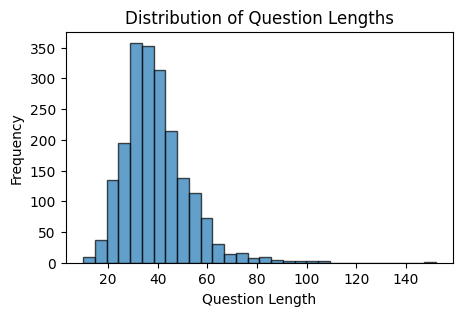

In [14]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering using TF-IDF

- TF-IDF 참고 링크: https://ko.wikipedia.org/wiki/Tf-idf

### Initialize TF-IDF Vectorizer

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

### Fit and transform the text data

In [16]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_question'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### Display the TF-IDF features

In [17]:
print("\nTF-IDF Features:")
display(tfidf_df.head(20))


TF-IDF Features:


11월  12월  1450  1450년에서  1750  1750년  17세기  19세기  1분기  1위를  2008년  2010년  \
0   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
1   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
2   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
3   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
4   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
5   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
6   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
7   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
8   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
9   0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
10  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
11  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
12  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
13  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
14  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
15  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
16  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
17  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
18  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   
19  0.0  0.0   0.0      0.0   0.0    0.0   0.0   0.0  0.0  0.0    0.0    0.0   

    2013년  2014  2014년  2014년도  2015학년도  2019  2019년  2020  2020년  20세기  2분기  \
0     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
1     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
2     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
3     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
4     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
5     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
6     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
7     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
8     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
9     0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
10    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
11    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
12    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
13    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
14    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
15    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
16    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
17    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
18    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   
19    0.0   0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   0.0  0.0   

    2에서  3분기   5년   5월  600  600년에서   7월  ceo가   eu  fed  gdp   of   가격  가격과  \
0   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7 

## Model Training

### Baseline Model

- https://huggingface.co/beomi/gemma-ko-2b

In [ ]:
# 본인의 Huggingface auth token 입력
## Jupyter lab에서 로그인 하는 textbox가 나오지 않을 경우, terminal에서 로그인 하실 수 있습니다.
# !huggingface-cli login


⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): Traceback (most recent call last):
  File "/data/ephemeral/pro-nlp-generationfornlp-nlp-13/.venv/bin/huggingface-cli", line 7, in <module>
    sys.exit(main())
  File "/data/ephemeral/pro-nlp-ge

모델과 토크나이저를 불러옵니다.

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen3-8B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [37]:
peft_config = LoraConfig(
    r=6,
    lora_alpha=8,
    lora_dropout=0.05,
    target_modules=['q_proj', 'k_proj'],
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
df = df[df['num_choices'] == 5]
dataset = Dataset.from_pandas(df)

In [ ]:
PROMPT_NO_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

선택지:
{choices}

지문에 따른 질문의 정답을 1, 2, 3, 4, 5 중에 찾으세요.
정답:"""

PROMPT_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

선택지:
{choices}

지문에 따른 질문의 정답을 1, 2, 3, 4, 5 중에 찾으세요.
정답:"""

In [43]:
processed_dataset = []
for i in range(len(dataset)):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(dataset[i]["choices"])])

    # <보기>가 있을 때
    if dataset[i]["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            question_plus=dataset[i]["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            choices=choices_string,
        )

    # chat message 형식으로 변환
    processed_dataset.append(
        {
            "id": dataset[i]["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": f"{dataset[i]['answer']}"}
            ],
            "label": dataset[i]["answer"],
        }
    )


In [44]:
processed_dataset[0]

{'id': 'generation-for-nlp-1380',
 'messages': [{'role': 'system', 'content': '지문을 읽고 질문의 답을 구하세요.'},
  {'role': 'user',
   'content': '지문:\n부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스사업화 지원사업’ 공모사업에 4개 과제가 선정되어 본격적인 사업 착수에 나선다. 과학기술정보통신부가 주관하는 ‘지역SW서비스사업화 지원사업’은 강소SW기업 및 초기 스타트업의 SW서비스 사업화 지원과 신시장 진출 지원을 통해 기업 경쟁력 강화와 지역경제 활성화를 도모하는 사업이다. 올해부터 2개년으로 진행되며, 국비와 시비, 민자 등 2년간 약 37억원의 예산이 투입된다. 앞서 진흥원은 부산의 미래 먹거리산업인 스마트해양, 지능형기계, 지능정보서비스 분야로 사전 수요조사를 진행했고, 평가를 통해 선정된 5개 과제를 공모사업에 신청했다. 그 결과 부산의 4개 과제가 최종 선정되는 쾌거를 거뒀다. 당 사업은 전국 진흥기관을 대상으로 공모를 시작해, 총 17개 지역에서 42개 과제가 선정되었으며, 4개 과제가 선정된 곳은 부산과 강원지역 뿐이다. 금번 선정된 과제들은 ‘인공지능융합센서와 서보 이송 로봇을 이용한 전단보강재의 자동용접시스템 개발’ 등 총 4개 과제다. 부산시가 지원하고, 부산정보산업진흥원과 지역기업, 대학, 연구소 등이 컨소시엄을 구성하여 기술개발 및 사업화 지원을 추진한다. 2개의 Track으로 구분되는 이번사업은 Track 1(SW중소기업)에서 ㈜에이아이플랫폼, 엔컴(주), Track 2(스타트업)에서는 ㈜토즈, 삼보테크놀로지를 지원한다. ○ ‘Track 1‘의 (주)에이아이플랫폼이 주관기업으로 진행하는 <인공지능 기반 망막 내 아밀로이드 플라크 영상 분석을 통한 치매조기진단 플랫폼 상용화>는 치매 확진의 원인이 되는 중요 단백질(아밀로이드 플라크)을 자체개발 관측장비로 진단한다. 이를 통해 치매를 조기 발견하여, 각종

In [45]:
processed_dataset = Dataset.from_pandas(pd.DataFrame(processed_dataset))
processed_dataset

Dataset({
    features: ['id', 'messages', 'label'],
    num_rows: 1239
})

In [ ]:

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_dataset.map(
    tokenize,
    remove_columns=list(processed_dataset.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=True,
    desc="Tokenizing",
)

Tokenizing (num_proc=4):   0%|          | 0/1239 [00:00<?, ? examples/s]

In [ ]:

tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test']
# 데이터 확인
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=True))

Filter:   0%|          | 0/1239 [00:00<?, ? examples/s]

system
지문을 읽고 질문의 답을 구하세요.
user
지문:
미국 제약회사 화이자의 영국 아스트라제네카 인수 재추진 소식이 들리면서 미국의 높은 법인세율이 또 도마에 올랐다. 화이자는 통합지주회사를 영국에 두고 연 600억파운드(약 104조1060억원)에 달하는 세금을 미국 대신 영국에 내겠다는 계획이다. 영국의 법인세율은 21%로 미국(32.8%)보다 10%포인트 이상 낮다. 이언 리드 화이자 최고경영자(CEO)는 “인수가 성사되면 27%의 법인세 절감 효과가 있다”고 밝혔다. 화이자뿐만 아니다. 최근 미국 제약업계는 잇따라 유럽행을 택하고 있다. 주로 현지 제약사를 인수합병(M&A)한 뒤 본사를 이전하는 방식이다. 파이낸셜타임스(FT)는 구글 애플 등 미국 정보기술(IT)기업에 이어 제약사까지 ‘절세 효과’를 노리고 유럽, 특히 아일랜드로 이동하고 있다고 30일 보도했다. 최근 몇 년 새 엔도헬스솔루션스, 포레스트랩스, 액타비스, 페리고 등 미국 제약사가 잇따라 아일랜드 회사에 투자했다. 엔도는 본사 이전 후 연 7500만달러의 세금절약 효과를 보고 있다. FT는 제약업계가 수익성 압박에 시달리면서 이 같은 행보가 더 빨라지고 있다고 전했다. 113년간 미국에 본사를 뒀던 미국 최대 약국체인 월그린 주주들은 최근 본사를 유럽으로 옮겨 수익을 더 올리라고 경영진을 압박하기도 했다.신용평가사 무디스에 따르면 지난해 말 미국 기업이 높은 세금을 회피하기 위해 해외에 쌓아둔 현금은 전년 대비 13% 증가한 9470억달러(약 978조원)로 사상 최고치를 경신했다. 미국 내 법인세 문제는 정계와 재계 갈등을 일으키는 ‘단골 이슈’다. 미 재무부와 정치권에서 기업의 조세회피 관행으로 인한 세입 손실이 막대하다는 비난을 쏟아내자 버락 오바마 대통령은 지난달 M&A를 통한 조세 회피를 법적으로 차단하겠다고 밝혔다.

질문:
화이자가 영국 아스트라제네카 인수를 통해 기대하는 법인세 절감 효과는 몇 퍼센트인가?

선택지:
1 - 10%
2 - 21%
3 - 27%
4 - 

In [ ]:

print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=False))

<|im_start|>system
지문을 읽고 질문의 답을 구하세요.<|im_end|>
<|im_start|>user
지문:
미국 제약회사 화이자의 영국 아스트라제네카 인수 재추진 소식이 들리면서 미국의 높은 법인세율이 또 도마에 올랐다. 화이자는 통합지주회사를 영국에 두고 연 600억파운드(약 104조1060억원)에 달하는 세금을 미국 대신 영국에 내겠다는 계획이다. 영국의 법인세율은 21%로 미국(32.8%)보다 10%포인트 이상 낮다. 이언 리드 화이자 최고경영자(CEO)는 “인수가 성사되면 27%의 법인세 절감 효과가 있다”고 밝혔다. 화이자뿐만 아니다. 최근 미국 제약업계는 잇따라 유럽행을 택하고 있다. 주로 현지 제약사를 인수합병(M&A)한 뒤 본사를 이전하는 방식이다. 파이낸셜타임스(FT)는 구글 애플 등 미국 정보기술(IT)기업에 이어 제약사까지 ‘절세 효과’를 노리고 유럽, 특히 아일랜드로 이동하고 있다고 30일 보도했다. 최근 몇 년 새 엔도헬스솔루션스, 포레스트랩스, 액타비스, 페리고 등 미국 제약사가 잇따라 아일랜드 회사에 투자했다. 엔도는 본사 이전 후 연 7500만달러의 세금절약 효과를 보고 있다. FT는 제약업계가 수익성 압박에 시달리면서 이 같은 행보가 더 빨라지고 있다고 전했다. 113년간 미국에 본사를 뒀던 미국 최대 약국체인 월그린 주주들은 최근 본사를 유럽으로 옮겨 수익을 더 올리라고 경영진을 압박하기도 했다.신용평가사 무디스에 따르면 지난해 말 미국 기업이 높은 세금을 회피하기 위해 해외에 쌓아둔 현금은 전년 대비 13% 증가한 9470억달러(약 978조원)로 사상 최고치를 경신했다. 미국 내 법인세 문제는 정계와 재계 갈등을 일으키는 ‘단골 이슈’다. 미 재무부와 정치권에서 기업의 조세회피 관행으로 인한 세입 손실이 막대하다는 비난을 쏟아내자 버락 오바마 대통령은 지난달 M&A를 통한 조세 회피를 법적으로 차단하겠다고 밝혔다.

질문:
화이자가 영국 아스트라제네카 인수를 통해 기대하는 법인세 절감 효과는 몇 퍼센트인가?


In [ ]:

train_dataset_token_lengths = [len(train_dataset[i]["input_ids"]) for i in range(len(train_dataset))]
print(f"max token length: {max(train_dataset_token_lengths)}")
print(f"min token length: {min(train_dataset_token_lengths)}")
print(f"avg token length: {np.mean(train_dataset_token_lengths)}")

max token length: 1023
min token length: 479
avg token length: 745.5767790262172


In [ ]:

print(tokenizer.chat_template)

{%- if tools %}
    {{- '<|im_start|>system\n' }}
    {%- if messages[0].role == 'system' %}
        {{- messages[0].content + '\n\n' }}
    {%- endif %}
    {{- "# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>" }}
    {%- for tool in tools %}
        {{- "\n" }}
        {{- tool | tojson }}
    {%- endfor %}
    {{- "\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call><|im_end|>\n" }}
{%- else %}
    {%- if messages[0].role == 'system' %}
        {{- '<|im_start|>system\n' + messages[0].content + '<|im_end|>\n' }}
    {%- endif %}
{%- endif %}
{%- set ns = namespace(multi_step_tool=true, last_query_index=messages|length - 1) %}
{%- for message in messages[::-1] %}
    {%- set index = (messages|length - 

Completion 부분만 학습하기 위한 data collator 설정

- 텍스트 중 response_template 까지는 ignore_index 로 loss 계산에서 제외
- 텍스트 중 response_template 이후는 학습에 포함 (정답 + eos 토큰)

In [51]:
response_template = "<start_of_turn>model"
data_collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template,
    tokenizer=tokenizer,
)

### Metric 설정

In [ ]:
# 모델의 logits 를 조정하여 정답 토큰 부분만 출력하도록 설정
def preprocess_logits_for_metrics(logits, labels):
    logits = logits if not isinstance(logits, tuple) else logits[0]
    logit_idx = [tokenizer.vocab["1"], tokenizer.vocab["2"], tokenizer.vocab["3"], tokenizer.vocab["4"], tokenizer.vocab["5"]]
    logits = logits[:, -2, logit_idx] # -2: answer token, -1: eos token
    return logits

# metric 로드
acc_metric = evaluate.load("accuracy")

# 정답 토큰 매핑
int_output_map = {"1": 0, "2": 1, "3": 2, "4": 3, "5": 4}

# metric 계산 함수
def compute_metrics(evaluation_result):
    logits, labels = evaluation_result

    # 토큰화된 레이블 디코딩
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    labels = list(map(lambda x: x.split("<end_of_turn>")[0].strip(), labels))
    labels = list(map(lambda x: int_output_map[x], labels))

    # 소프트맥스 함수를 사용하여 로그트 변환
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)
    predictions = np.argmax(probs, axis=-1)

    # 정확도 계산
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return acc


### Train

In [ ]:
# pad token 설정
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.special_tokens_map


{'eos_token': '<|im_end|>',
 'pad_token': '<|im_end|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

In [ ]:
tokenizer.padding_side = 'right'

sft_config = SFTConfig(
    do_train=True,
    do_eval=True,
    lr_scheduler_type="cosine",
    max_seq_length=1024,
    output_dir="outputs_gemma",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,
    save_only_model=True,
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    peft_config=peft_config,
    args=sft_config,
)


/data/ephemeral/pro-nlp-generationfornlp-nlp-13/.venv/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [56]:
%%time

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151645}.
/data/ephemeral/pro-nlp-generationfornlp-nlp-13/.venv/lib/python3.10/site-packages/trl/trainer/utils.py:156: UserWarning: Could not find response key `<start_of_turn>model` in the following instance: <|im_start|>system
지문을 읽고 질문의 답을 구하세요.<|im_end|>
<|im_start|>user
지문:
양파와 설탕 등 식품가격 안정이 나렌드라 모디 인도 총리(사진)의 가장 중요한 과제가 됐다고 파이낸셜타임스가 12일 보도했다. 인도 국민의 30%가량이 소득의 절반 이상을 식료품에 지출하고 있기 때문에 식품 가격 상승은 인도 가계에 큰 부담이다.특히 양파와 설탕은 대부분 인도 요리에 사용되는 중요한 식품이다. 최근 양파와 설탕 가격이 꾸준히 오르면서 인도 소비자물가지수(CPI)도 상승 압박을 받고 있다. 전문가들은 인도의 지난달 CPI가 전년 동기 대비 7.4% 올랐을 것으로 추정했다. 지난 6월 상승률(7.3%)을 웃도는 수치다.올해는 예년보다 건조한 날씨 탓에 농작물 작황이 제대로 되지 않아 야채와 과일 가격이 오르고 있다. 남은 우기 동안 강우량이 많지 않으면 인도 물가는 더욱 치솟을 가능성이 크다. 이렇다 보니 모디 총리는 물가 안정화를 인도 정부의 우선 과제로 삼고 있다. 10%에 육박하는 물가상승률을 

Epoch,Training Loss,Validation Loss


/data/ephemeral/pro-nlp-generationfornlp-nlp-13/.venv/lib/python3.10/site-packages/trl/trainer/utils.py:156: UserWarning: Could not find response key `<start_of_turn>model` in the following instance: <|im_start|>system
지문을 읽고 질문의 답을 구하세요.<|im_end|>
<|im_start|>user
지문:
북한 경제가 3년 연속 플러스 성장을 했지만 남한과의 경제 격차는 더 벌어졌다. 북한의 1인당 국민총소득(GNI)은 남한의 21분의 1에 불과했다.한국은행이 27일 발표한 ‘2013년 북한 경제성장률 추정 결과’에 따르면 지난해 북한의 실질 국내총생산(GDP)은 전년보다 1.1% 증가한 30조8392억원으로 추산됐다. 이는 한은이 관계기관으로부터 북한의 경제활동과 관련된 기초자료를 받아 추정한 값이다. 북한 경제는 2011년 0.8%, 2012년 1.3%에 이어 3년 연속 성장했다. 2009년(-0.9%)과 2010년(-0.5%)에는 마이너스 성장률을 보였다.지난해 북한 경제가 성장한 것은 토목건설 부진으로 건설업은 위축됐으나 기상여건 호조 덕분에 농작물 생산이 늘어나고 석탄과 철광석 등 광물자원 생산이 증가한 데 힘입었다. 명목 GDP의 22.4%를 차지한 농림어업 생산이 1.9% 늘었다. 광업(GDP 비중 13.6%) 생산도 2.1% 늘어났다. 제조업(22.1%)과 서비스업(30%) 생산은 각각 1.1%, 0.3% 증가했다. 경공업은 식료품과 섬유·의복 및 신발을 위주로 1.4% 늘었다. 그러나 남북 간 소득 격차는 더 벌어졌다. 2013년 북한의 명목 GNI는 33조8000억원으로 추정됐다. 이는 남한(1441조1000억원)의 42.6분의 1로, 2012년(41.6분의 1)보다 커졌다. 명목 GNI를 인구 수로 나눈 북한의 1인당 GNI는 137만9000원이었다. 남한(2869만5

KeyboardInterrupt: 

## Inference

In [ ]:
# TODO 학습된 Checkpoint 경로 입력
checkpoint_path = "outputs_gemma/checkpoint-4491"

model = AutoPeftModelForCausalLM.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
    # torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
)

In [ ]:
# Load the test dataset
# TODO Test Data 경로 입력
test_df = pd.read_csv('test.csv')

# Flatten the JSON dataset
records = []
for _, row in test_df.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
test_df = pd.DataFrame(records)

In [ ]:
test_dataset = []
for i, row in test_df.iterrows():
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(row["choices"])])
    len_choices = len(row["choices"])
    
    # <보기>가 있을 때
    if row["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            question=row["question"],
            question_plus=row["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            question=row["question"],
            choices=choices_string,
        )

    test_dataset.append(
        {
            "id": row["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
            ],
            "label": row["answer"],
            "len_choices": len_choices,
        }
    )

In [ ]:
%%time

infer_results = []

pred_choices_map = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"}

model.eval()
with torch.inference_mode():
    for data in tqdm(test_dataset):
        _id = data["id"]
        messages = data["messages"]
        len_choices = data["len_choices"]

        outputs = model(
            tokenizer.apply_chat_template(
                messages,
                tokenize=True,
                add_generation_prompt=True,
                return_tensors="pt",
            ).to("cuda")
        )

        logits = outputs.logits[:, -1].flatten().cpu()

        target_logit_list = [logits[tokenizer.vocab[str(i + 1)]] for i in range(len_choices)]

        probs = (
            torch.nn.functional.softmax(
                torch.tensor(target_logit_list, dtype=torch.float32)
            )
            .detach()
            .cpu()
            .numpy()
        )

        predict_value = pred_choices_map[np.argmax(probs, axis=-1)]
        infer_results.append({"id": _id, "answer": predict_value})

In [ ]:
pd.DataFrame(infer_results).to_csv("output.csv", index=False)

In [ ]:
pd.DataFrame(infer_results)